In [1]:
import os
import numpy as np
import pandas as pd
from time import sleep
from tqdm import tqdm
from PIL import Image
from pathlib import Path

import torch
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation

In [10]:
processor_depth = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-nyu")
model_depth = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

processor_mask = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-small-coco")
model_mask = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-small-coco")

d:\miniconda3\lib\site-packages\transformers\models\glpn\feature_extraction_glpn.py:28: FutureWarning: The class GLPNFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use GLPNImageProcessor instead.
  warnings.warn(
d:\miniconda3\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:401: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
d:\miniconda3\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:408: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


In [14]:
def get_depth(img):
    img = img.resize((512,512))
    inputs_d = processor_depth(img, return_tensors="pt").pixel_values

    import torch
    with torch.no_grad():
        outputs_d = model_depth(inputs_d)
        predicted_depth = outputs_d.predicted_depth
        predicted_depth.shape
    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
                        predicted_depth.unsqueeze(1),
                        size=inputs_d.shape[-2:],
                        mode="bicubic",
                        align_corners=False,
                )
    depth = prediction.squeeze().cpu().numpy()
    
    return depth

def get_mask(img):
    inputs_m = processor_mask(images=img, return_tensors="pt")
    outputs_m = model_mask(**inputs_m)
    predicted_semantic_map = processor_mask.post_process_semantic_segmentation(outputs_m, target_sizes=[img.size[::-1]])[0]

    return predicted_semantic_map

def get_nature_depth(img, label = None):
    #125:grass; 116:tree
    mask = get_mask(img)
    pre_depth = get_depth(img)
    
    mask = (np.array(mask) == label).astype(int) 
    # pre_depth_mask = (pre_depth * mask).reshape(-1) [(pre_depth * mask).reshape(-1) != 0]
    pre_depth_mask = (pre_depth * mask)  ##visual elements depth
    
    return pre_depth_mask
    # return mask

In [11]:
input_dir = "D:/研究生/01Master/JNU/samples"
output_file = "D:/desk/depth_restoration/depth.csv"

all_data = []
for image_path in tqdm(Path(input_dir).glob("*.jpg")):
    image = Image.open(image_path)
    image = image.resize((512, 512))

    depth = get_nature_depth(image, label=116)  # 125:grass; 116:tree

    # Append data to list of all data
    data = {"filename": image_path.name}
    if depth.size > 0:
        data["depth_mean"] = depth.mean()
    else:
        data["depth_mean"] = None
    
    if depth.size > 0:
        data["depth_max"] = depth.max()
    else:
        data["depth_max"] = None
        
    if depth.size > 0:
        data["depth_min"] = depth.min()
    else:
        data["depth_min"] = None
    
    all_data.append(data)

# Save data to CSV file
df = pd.DataFrame.from_records(all_data, columns=["filename"] + ["depth_mean"] + ["depth_max"] + ["depth_min"])
df.set_index("filename", inplace=True)
df.to_csv(output_file)

0it [00:00, ?it/s]

200it [26:58,  8.09s/it]


In [7]:
# Save data to CSV file
df = pd.DataFrame.from_records(all_data, columns=["filename"] + ["total_pixels"])
df.set_index("filename", inplace=True)
df.to_csv(output_file)

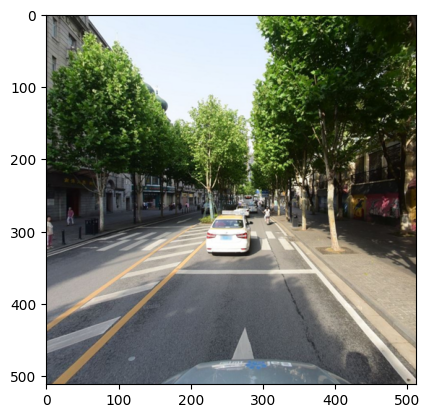

In [15]:
import matplotlib.pyplot as plt

# X = Image.open("D:/desk/test.jpg")
X = Image.open("D:/desk/depth_restoration/figure/2023sample.png")

img = X.resize((512,512))
plt.imshow(img)

#### 119 sky, 129 building, 100 road, 125 grass; 116 tree; 2 car

In [29]:
DEPTH = get_nature_depth(img, label=116)
DEPTH.mean()

3.663310415575512

In [30]:
DEPTH = get_nature_depth(img, label=125)
DEPTH.mean()

3.0996248622537843

In [16]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 5))
plt.imshow(get_nature_depth(img, label=116))
# plt.savefig("D:/desk/JNU/imgdepth.jpg", dpi = 600)

ValueError: Unable to infer channel dimension format

In [1]:
import xgboost as xgb

In [3]:
xgb.__version__

'1.7.4'

In [17]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler

In [27]:
import pandas as pd
import numpy as np

# 读取 CSV 文件
data = pd.read_csv(r"D:\A_Research\A_doing_research\20240710_depth+restoration+wuhan\depth_wuhan.csv")

# # 定义一个函数来移除异常值
# def remove_outliers(df, column):
#     df = df[df[column] != 0]
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
#     return df

# # 对 grass_depth_mean 和 tree_depth_mean 列应用移除异常值的函数
# data = remove_outliers(data, 'grass_depth_mean')
# data = remove_outliers(data, 'tree_depth_mean').reset_index()

X = data.iloc[:,4:] # 自变量x1和x2...
y = data.iloc[:,1] # 因变量y

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(np.array(y).reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
y_train

array([0.71628959, 0.11904531, 0.15468668, 0.37251639, 0.17070288,
       0.17385506, 0.22553563, 0.48510673, 0.24019744, 0.55327863,
       0.30628401, 0.14369316, 0.15012113, 0.22482101, 0.17493484,
       0.94439201, 0.27369556, 0.1716105 , 0.29439895, 0.17451681,
       0.15734626, 0.15753018, 0.17420317, 0.30033813, 0.56883247,
       0.17486858, 0.40868222, 0.16777868, 0.15847542, 0.23910722,
       0.16940664, 0.15750866, 0.71392447, 0.16729874, 0.16939949,
       0.12585792, 0.12193501, 0.15113746, 0.24067237, 0.42898674,
       0.16689171, 0.55844739, 0.47025303, 0.61253851, 0.16950659,
       0.72943052, 0.38042944, 0.80865009, 0.14554209, 0.14653148,
       0.16652209, 0.14552374, 0.22449474, 0.23613368, 0.79419424,
       0.17135787, 0.17525483, 0.17583709, 0.30568745, 0.37352751,
       0.26531734, 0.16720764, 0.24794078, 0.36733179, 0.15959885,
       0.42104943, 0.15475555, 0.43189116, 0.26765801, 0.37528615,
       0.1629314 , 0.17631275, 0.72175888, 0.24808295, 0.15316

In [26]:
## 归一化

from sklearn.preprocessing import MinMaxScaler

col_to_normalize = data.columns[1:]
print(col_to_normalize)

scaler = MinMaxScaler()
data[col_to_normalize] = scaler.fit_transform(data[col_to_normalize])
data.to_csv(r"D:\A_Research\A_doing_research\20240710_depth+restoration+wuhan\depth_wuhan_nor.csv", index = False)
print(data)

Index(['average_score', 'labels_three', 'label_average', 'grass_depth_mean',
       'grass_depth_max', 'grass_depth_min', 'tree_depth_mean',
       'tree_depth_max', 'tree_depth_min', 'building_seg', 'tree_seg',
       'road_seg', 'sky_seg', 'car_seg', 'plant_seg', 'van_seg',
       'sidewalk_seg', 'person_seg', 'bus_seg', 'fence_seg', 'grass_seg',
       'car_obj', 'person_obj', 'truck_obj', 'motorcycle_obj', 'bicycle_obj',
       'hue_mean', 'saturation_mean', 'light_mean', 'edge_mean'],
      dtype='object')
                             filename  average_score  labels_three  \
0     114.156143869_30.6128186974.png       0.000000           0.0   
1     114.158411111_30.6206021664.png       0.537575           0.5   
2       114.15942885_30.574736697.png       0.408682           0.5   
3     114.159630471_30.5788771409.png       0.558447           0.5   
4      114.15989869_30.6073719864.png       0.700706           1.0   
...                               ...            ...           

In [29]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb

regressors = {
    "Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Linear SVM": SVR(kernel="linear", gamma=2, C=1),
    "RBF SVM": SVR(kernel="rbf", gamma=2, C=1),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, 
                                         random_state=42),
    "Random Forest": RandomForestRegressor(max_depth=15, 
                                         n_estimators=5000, 
                                         random_state=42),
    "XGBoost": xgb.XGBRegressor(learning_rate=0.01,
                               n_estimators=5000,
                               max_depth=15,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               reg_alpha=0.1,
                               reg_lambda=0.1,
                               random_state=42),
    "Neural Net": MLPRegressor(alpha=1, 
                              learning_rate_init=0.001,
                              max_iter=5000, 
                              random_state=42)
}

In [37]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 定义回归器
regressors = {
    "Linear SVM": SVR(kernel="linear", gamma=2, C=1),
    "Random Forest": RandomForestRegressor(max_depth=15, 
                                         n_estimators=5000, 
                                         random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, 
                                         random_state=42),
    "XGBoost": xgb.XGBRegressor(learning_rate=0.01,
                               n_estimators=5000,
                               max_depth=15,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               reg_alpha=0.1,
                               reg_lambda=0.1,
                               random_state=42),
    "GBDT": GradientBoostingRegressor(n_estimators=5000,
                                     learning_rate=0.01,
                                     max_depth=15,
                                     random_state=42),
    "Neural Net": MLPRegressor(alpha=1, 
                              learning_rate_init=0.001,
                              max_iter=5000, 
                              random_state=42)
}

# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储每个模型在每个折叠上的性能
results = {name: {'RMSE': [], 'MSE': [], 'R2': []} for name in regressors.keys()}

# 对每个模型进行交叉验证
for name, model in regressors.items():
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        # 分割数据
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # 训练模型
        model.fit(X_train, y_train)
        
        # 预测
        y_pred = model.predict(X_val)
        
        # 计算评估指标
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, y_pred)
        
        # 存储结果
        results[name]['RMSE'].append(rmse)
        results[name]['MSE'].append(mse)
        results[name]['R2'].append(r2)

# 计算平均性能指标
avg_results = {}
for name in results:
    avg_results[name] = {
        'RMSE': np.mean(results[name]['RMSE']),
        'MSE': np.mean(results[name]['MSE']),
        'R2': np.mean(results[name]['R2']),
        'RMSE_std': np.std(results[name]['RMSE']),
        'MSE_std': np.std(results[name]['MSE']),
        'R2_std': np.std(results[name]['R2'])
    }

# 将结果转换为DataFrame并打印
results_df = pd.DataFrame.from_dict(avg_results, orient='index')
print("\nAverage Model Performance (5-fold CV):")
print(results_df)

# 找出表现最好的模型（基于R2分数）
best_model = results_df['R2'].idxmax()
print(f"\nBest performing model based on average R2 score: {best_model}")
print(f"Average R2 score: {results_df.loc[best_model, 'R2']:.4f} ± {results_df.loc[best_model, 'R2_std']:.4f}")
print(f"Average RMSE: {results_df.loc[best_model, 'RMSE']:.4f} ± {results_df.loc[best_model, 'RMSE_std']:.4f}")


Average Model Performance (5-fold CV):
                   RMSE       MSE        R2  RMSE_std   MSE_std    R2_std
Linear SVM     0.188106  0.035427  0.283800  0.006580  0.002476  0.041621
Random Forest  0.180349  0.032616  0.340227  0.009498  0.003405  0.068871
Decision Tree  0.209683  0.044020  0.109489  0.007307  0.003036  0.060484
XGBoost        0.177149  0.031454  0.363689  0.008474  0.003010  0.061248
GBDT           0.241899  0.058600 -0.188684  0.009228  0.004566  0.125651
Neural Net     0.215804  0.046611  0.058232  0.006275  0.002735  0.023912

Best performing model based on average R2 score: XGBoost
Average R2 score: 0.3637 ± 0.0612
Average RMSE: 0.1771 ± 0.0085



First few rows of the generated data:
   predict_grass_depth  human_grass_depth  predict_tree_depth  \
0             3.235718           2.113912            3.814128   
1             2.404512           1.500000            3.992910   
2             3.716353           2.987051            3.410755   
3             2.843674           1.770991            3.472778   
4             2.639706           2.530532            3.077304   

   human_tree_depth  
0          3.153325  
1          3.115873  
2          3.109848  
3          3.132208  
4          2.855469  


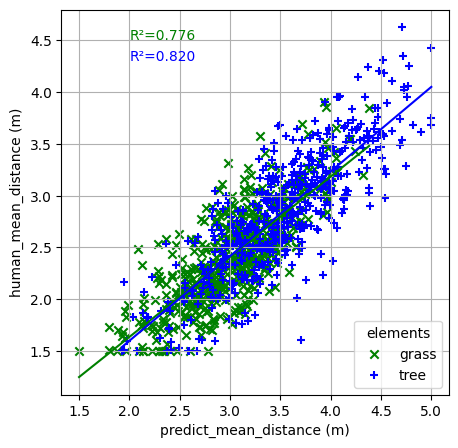

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 保存到CSV文件
df = pd.read_csv(r'D:\A_Research\A_doing_research\20240710_depth+restoration+wuhan\depth_samples.csv')

# 显示前几行数据
print("\nFirst few rows of the generated data:")
print(df.head())

# 创建图形
plt.figure(figsize=(5, 5))

# 绘制散点图和回归线
# 草地数据
grass = plt.scatter(df['predict_grass_depth'], df['human_grass_depth'], 
                   marker='x', color='green', label='grass')
z_grass = np.polyfit(df['predict_grass_depth'], df['human_grass_depth'], 1)
p_grass = np.poly1d(z_grass)
x_grass = np.linspace(df['predict_grass_depth'].min(), df['predict_grass_depth'].max(), 100)
plt.plot(x_grass, p_grass(x_grass), 'g-')

# 树木数据
tree = plt.scatter(df['predict_tree_depth'], df['human_tree_depth'], 
                  marker='+', color='blue', label='tree')
z_tree = np.polyfit(df['predict_tree_depth'], df['human_tree_depth'], 1)
p_tree = np.poly1d(z_tree)
x_tree = np.linspace(df['predict_tree_depth'].min(), df['predict_tree_depth'].max(), 100)
plt.plot(x_tree, p_tree(x_tree), 'b-')

# 计算相关系数
r2_grass = np.corrcoef(df['predict_grass_depth'], df['human_grass_depth'])[0,1]
r2_tree = np.corrcoef(df['predict_tree_depth'], df['human_tree_depth'])[0,1]

# 添加R²值到图例
plt.text(2, 4.5, f'R²={r2_grass:.3f}', color='green')
plt.text(2, 4.3, f'R²={r2_tree:.3f}', color='blue')

# 设置图形属性
plt.xlabel('predict_mean_distance (m)')
plt.ylabel('human_mean_distance (m)')
plt.grid(True)
plt.legend(title='elements', loc='lower right')

# 设置坐标轴范围
# plt.xlim(1.5, 5)
# plt.ylim(1.5, 5)

plt.show()

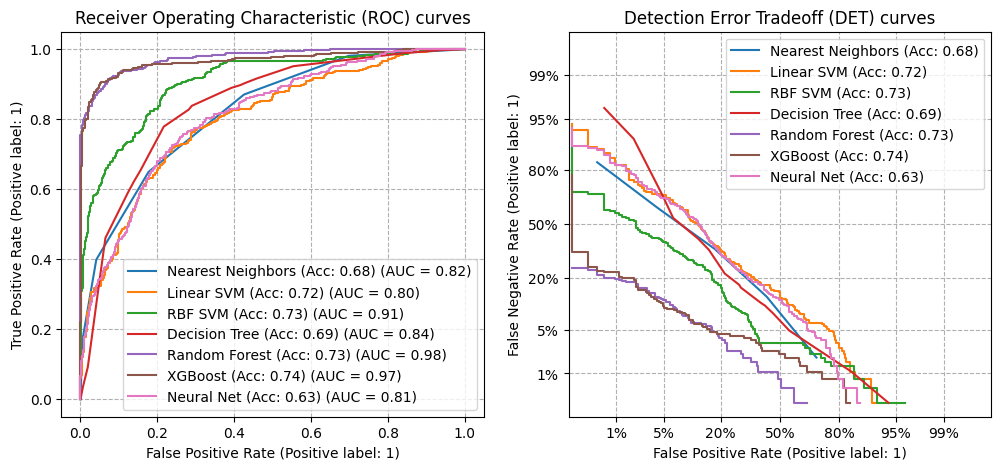

In [45]:
import matplotlib.pyplot as plt

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(12, 5))

for name, clf in classifiers.items():
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')  # 使用5倍交叉验证
    mean_score = np.mean(scores)

    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X, y, ax=ax_roc, name=f"{name} (Acc: {mean_score:.2f})")
    DetCurveDisplay.from_estimator(clf, X, y, ax=ax_det, name=f"{name} (Acc: {mean_score:.2f})")

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
# plt.savefig("D:/desk/depth_restoration/figure/roc_curve.svg")
plt.show()

In [10]:
# -*- coding: utf-8 -*-
from sklearn.metrics import accuracy_score, classification_report

xgb_cls = xgb.XGBClassifier(objective="binary:logistic", # 分类目标函数
                            learning_rate=0.01,
                            n_estimators=5000,
                            max_depth=15,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            reg_alpha=0.1,
                            reg_lambda=0.1,
                            random_state=50)

# 使用5折交叉验证
cv_scores = cross_val_score(xgb_cls, X_train, y_train, cv=5, scoring='accuracy')

# 打印准确率得分
print("Cross-validation scores: ", cv_scores)
# print("Mean score: ", cv_scores.mean())

xgb_cls.fit(X_train, y_train)

y_pred = xgb_cls.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# 打印分类报告
classification_rep = classification_report(y_test, y_pred)
print('Classification Report:')
print(classification_rep)

Cross-validation scores:  [0.93323963 0.92621223 0.92691497 0.91075193 0.92616034]
Accuracy: 0.938167509836987
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1034
           1       0.94      0.91      0.92       745

    accuracy                           0.94      1779
   macro avg       0.94      0.93      0.94      1779
weighted avg       0.94      0.94      0.94      1779



In [12]:
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[991,  43],
       [ 67, 678]], dtype=int64)

In [48]:
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[156,  26],
       [ 46,  73]], dtype=int64)

In [35]:
# 从本地读取CSV文件并创建数据帧
data = pd.read_csv(r'D:\A_Research\A_doing_research\20240710_depth+restoration+wuhan\depth_wuhan_total_normalize.csv')
data.head(2)

test_features = data.iloc[:,4:] # 自变量x1和x2...

In [36]:
test_features

,grass_depth_mean,tree_depth_mean,building_seg,tree_seg,road_seg,sky_seg,car_seg,plant_seg,van_seg,sidewalk_seg,...,grass_seg,car_obj,person_obj,truck_obj,motorcycle_obj,bicycle_obj,hue_mean,saturation_mean,light_mean,edge_mean
0,0.000000,0.296287,0.3558,0.226778,0.130777,0.000184,0.475018,0.000000,0.057308,0.000000,...,0.000000,0.619048,0.0625,0.000000,0.00,0.0,0.433898,0.273465,0.405155,0.633457
1,0.421031,0.383017,0.0261,0.130125,0.643794,0.752982,0.057940,0.007249,0.000000,0.062716,...,0.098356,0.000000,0.0000,0.000000,0.00,0.0,0.664240,0.157140,0.579540,0.227502
2,0.318701,0.362963,0.0231,0.102350,0.381635,0.795192,0.101337,0.000000,0.000000,0.028642,...,0.382960,0.047619,0.0000,0.142857,0.00,0.0,0.592317,0.203886,0.608284,0.316406
3,0.293501,0.293394,0.0593,0.104792,0.396367,0.806570,0.109313,0.008487,0.000000,0.037284,...,0.112706,0.000000,0.0000,0.000000,0.00,0.0,0.589741,0.175323,0.620265,0.251676
4,0.000000,0.230534,0.0392,0.006511,0.701110,0.967150,0.100399,0.000000,0.011190,0.000000,...,0.000000,0.476190,0.0000,0.000000,0.00,0.0,0.712263,0.056424,0.637617,0.074700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15770,0.412831,0.422402,0.1018,0.043545,0.711604,0.750229,0.016420,0.000884,0.024076,0.005185,...,0.022720,0.190476,0.0000,0.142857,0.00,0.0,0.519324,0.150144,0.646828,0.231011
15771,0.448269,0.417362,0.0867,0.066741,0.768920,0.740870,0.049496,0.000000,0.000000,0.025926,...,0.008969,0.000000,0.0000,0.000000,0.00,0.0,0.728645,0.141031,0.579292,0.161931
15772,0.168558,0.359243,0.1473,0.051582,0.030071,0.633511,0.000000,0.038190,0.000000,0.000000,...,0.000000,0.095238,0.0000,0.000000,0.00,0.0,0.687341,0.216284,0.611205,0.150178
15773,0.000000,0.397328,0.2940,0.131855,0.383855,0.142228,0.234342,0.000000,0.002035,0.309136,...,0.000000,0.619048,0.0625,0.142857,0.05,0.0,0.250584,0.259853,0.273147,0.235021


In [8]:
predictions = xgb_cls.predict(test_features)
print(predictions)

np.savetxt('D:/desk/depth_restoration/predict_result.csv', predictions, delimiter=',')

[1 1 1 ... 0 0 0]


In [14]:
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码

In [15]:
explainer = shap.TreeExplainer(xgb_cls)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
shap_values

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


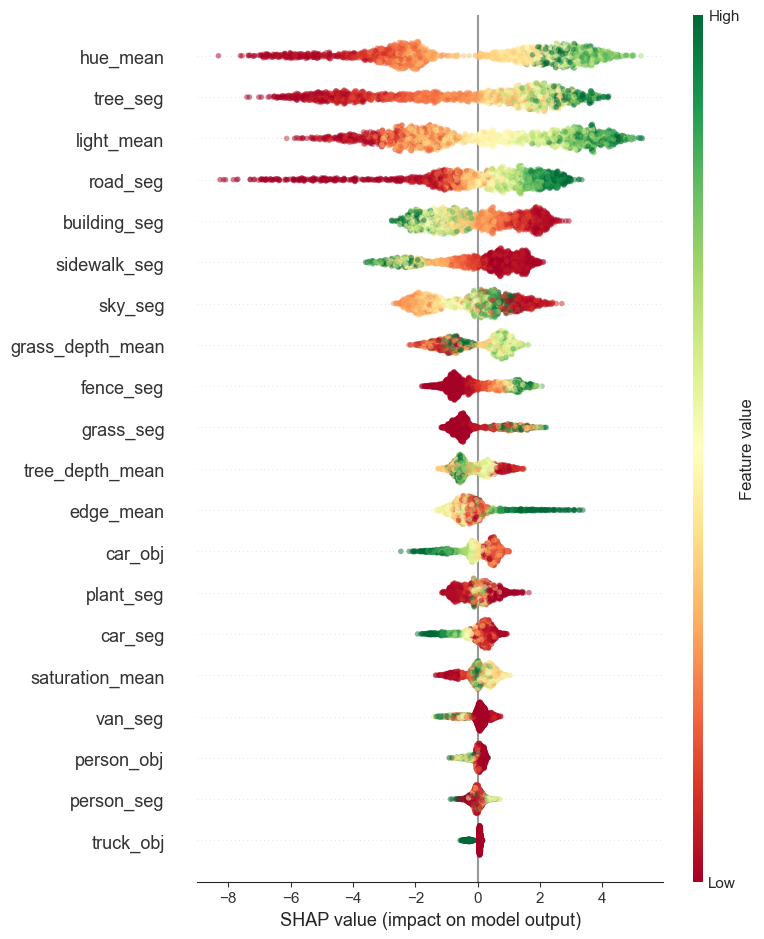

In [34]:
shap.summary_plot(shap_values, X_test, max_display=20, alpha=0.5, cmap="RdYlGn", show=False)
plt.savefig("D:/desk/shap.png", dpi = 600)

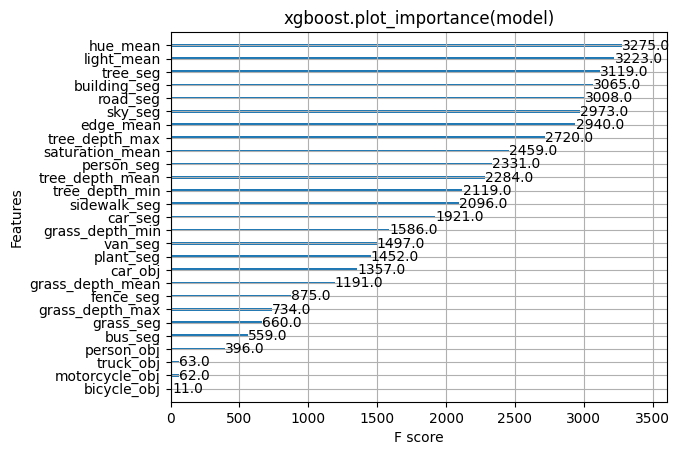

In [83]:
xgb.plot_importance(xgb_cls)
plt.title("xgboost.plot_importance(model)")
plt.show()

In [145]:
shap.plots.scatter??

Signature:
shap.plots.scatter(
    shap_values,
    color='#1E88E5',
    hist=True,
    axis_color='#333333',
    cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x000002028E1908E0>,
    dot_size=16,
    x_jitter='auto',
    alpha=1,
    title=None,
    xmin=None,
    xmax=None,
    ymin=None,
    ymax=None,
    overlay=None,
    ax=None,
    ylabel='SHAP value',
    show=True,
)
Source:   
def scatter(shap_values, color="#1E88E5", hist=True, axis_color="#333333", cmap=colors.red_blue,
            dot_size=16, x_jitter="auto", alpha=1, title=None, xmin=None, xmax=None, ymin=None, ymax=None,
            overlay=None, ax=None, ylabel="SHAP value", show=True):
    """ Create a SHAP dependence scatter plot, colored by an interaction feature.

    Plots the value of the feature on the x-axis and the SHAP value of the same feature
    on the y-axis. This shows how the model depends on the given feature, and is like a
    richer extenstion of classical parital dependence plots. Vert

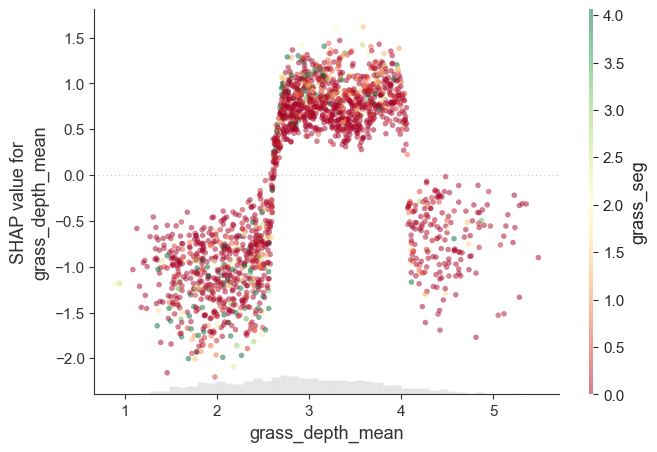

In [35]:
sns.set_style('white')

import matplotlib.pyplot as plt
shap.plots.scatter(shap_values[:, 0], color=shap_values[:, 13], cmap="RdYlGn", alpha=0.5, show=False)
plt.savefig("D:/desk/grass_shap.png",dpi = 600,)

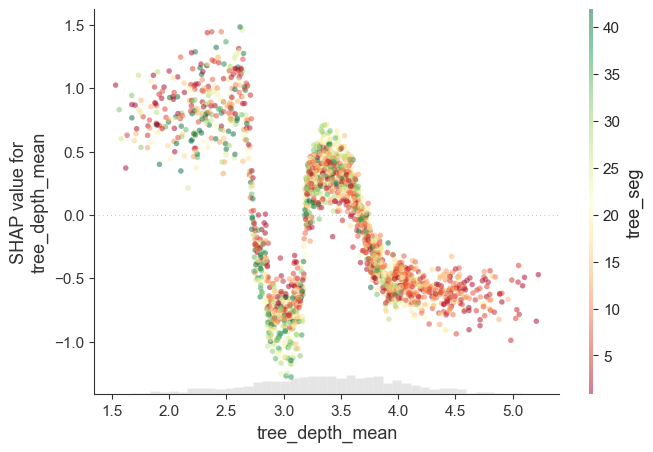

In [36]:
import matplotlib.pyplot as plt
shap.plots.scatter(shap_values[:, 1], color=shap_values[:, 3], cmap="RdYlGn", alpha=0.5, show=False)
plt.savefig("D:/desk/tree_shap.png",dpi = 600,)

In [142]:
shap_values[:, 0]

.values =
array([-0.20567846, -0.2032096 ,  0.5396826 , ..., -0.18486111,
       -0.15992723, -0.21604717], dtype=float32)

.base_values =
array([-0.6117851, -0.6117851, -0.6117851, ..., -0.6117851, -0.6117851,
       -0.6117851], dtype=float32)

.data =
array([0.        , 0.        , 0.31836224, ..., 0.        , 0.        ,
       0.        ])

In [147]:
X

,grass_depth_mean,grass_depth_max,grass_depth_min,tree_depth_mean,tree_depth_max,tree_depth_min,building_seg,tree_seg,road_seg,sky_seg,...,grass_seg,car_obj,person_obj,truck_obj,motorcycle_obj,bicycle_obj,hue_mean,saturation_mean,light_mean,edge_mean
0,0.000000,0.000000,0.000000,0.173729,0.138277,0.164334,0.9490,0.006027,0.000000,0.087942,...,0.000000,0.117647,0.0,0.0,0.0,0.0,0.158622,0.282776,0.509291,0.342550
1,0.000000,0.000000,0.000000,0.238969,0.388376,0.184943,0.5132,0.282342,0.225672,0.180770,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.479558,0.195039,0.644679,0.296148
2,0.318362,0.231459,0.299459,0.334408,0.378738,0.212646,0.4076,0.057553,0.548888,0.000782,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.699640,0.159859,0.476380,0.398390
3,0.000000,0.000000,0.000000,0.492871,0.446170,0.291371,0.0114,0.044898,0.946247,0.829197,...,0.000000,0.117647,0.0,0.0,0.0,0.0,0.564542,0.067729,0.673040,0.195273
4,0.000000,0.000000,0.000000,0.258473,0.289322,0.174718,0.0552,0.378767,0.190222,0.730702,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.438330,0.224213,0.786590,0.475640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,0.323828,0.339115,0.276616,0.241157,0.295198,0.160439,0.3773,0.220972,0.462929,0.025796,...,0.080264,0.117647,0.0,0.0,0.0,0.0,0.307105,0.129790,0.710562,0.246596
999,0.000000,0.000000,0.000000,0.225148,0.232688,0.183073,0.2840,0.085777,0.401993,0.696502,...,0.000000,0.235294,0.0,0.0,0.0,0.0,0.686736,0.068183,0.658650,0.167346
1000,0.000000,0.000000,0.000000,0.227676,0.197581,0.199825,0.0518,0.028224,0.702502,0.668947,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.588536,0.161267,0.745995,0.283525
1001,0.000000,0.000000,0.000000,0.366205,0.547377,0.269960,0.0894,0.014966,0.340593,0.866328,...,0.000000,0.235294,0.0,0.0,0.0,0.0,0.676159,0.062683,0.864528,0.195190


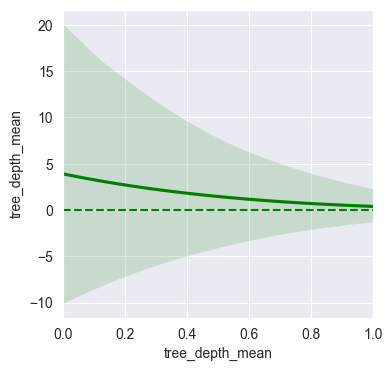

In [22]:
import seaborn as sns
import shap

plt.figure(figsize=(4, 4))

sns.set_style('darkgrid')
# 创建SHAP值的DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
merged_data = pd.concat([shap_df['tree_depth_mean'], X['tree_depth_mean']], axis=1)
# 绘制散点图
# sns.scatterplot(data=merged_data, x = merged_data.iloc[:,1], y = merged_data.iloc[:,0], size=0.1)
sns.regplot(
    data=merged_data, x = merged_data.iloc[:,1], y = merged_data.iloc[:,0],
    scatter=False, truncate=False, order=5, color="green")

plt.axhline(y=0, color='green', linestyle='--')

plt.show()

In [178]:
sns.regplot??

Signature:
sns.regplot(
    data=None,
    *,
    x=None,
    y=None,
    x_estimator=None,
    x_bins=None,
    x_ci='ci',
    scatter=True,
    fit_reg=True,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    order=1,
    logistic=False,
    lowess=False,
    robust=False,
    logx=False,
    x_partial=None,
    y_partial=None,
    truncate=True,
    dropna=True,
    x_jitter=None,
    y_jitter=None,
    label=None,
    color=None,
    marker='o',
    scatter_kws=None,
    line_kws=None,
    ax=None,
)
Docstring:
Plot data and a linear regression model fit.

There are a number of mutually exclusive options for estimating the
regression model. See the :ref:`tutorial <regression_tutorial>` for more
information.    

Parameters
----------
x, y: string, series, or vector array
    Input variables. If strings, these should correspond with column names
    in ``data``. When pandas objects are used, axes will be labeled with
    the series name.
data : DataFrame
    Tidy ("long-

<AxesSubplot: xlabel='cylinders', ylabel='acceleration'>

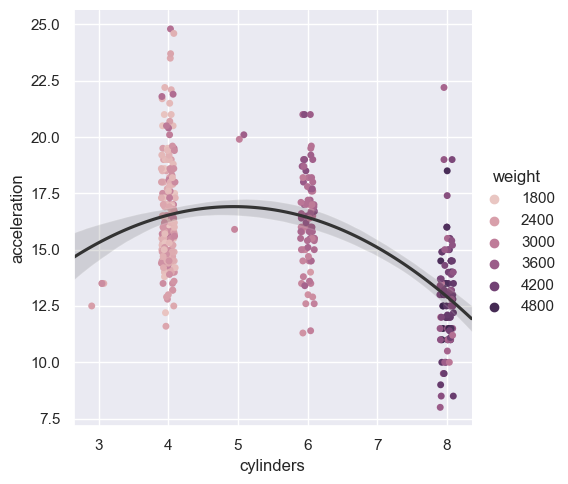

In [151]:
import seaborn as sns
sns.set_theme()

mpg = sns.load_dataset("mpg")
sns.catplot(
    data=mpg, x="cylinders", y="acceleration", hue="weight",
    native_scale=True, zorder=1
)
sns.regplot(
    data=mpg, x="cylinders", y="acceleration",
    scatter=False, truncate=False, order=2, color=".2",
)

In [98]:
shap.dependence_plot(4, shap_values[:,1], X, cmap="PiYG")

TypeError: order must be str, not int

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=6).fit_transform(shap_values[:1000, :])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000, :])

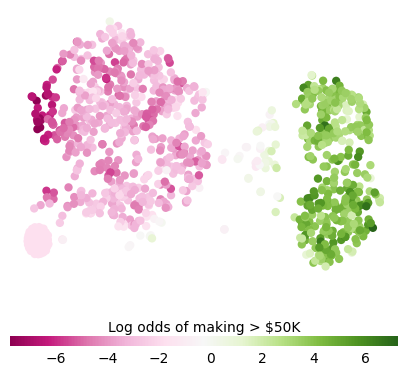

In [44]:
import matplotlib.pylab as pl

f = pl.figure(figsize=(5, 5))
pl.scatter(
    shap_embedded[:, 0],
    shap_embedded[:, 1],
    c=shap_values[:1000, :].sum(1).astype(np.float64),
    linewidth=0,
    alpha=1.0,
    cmap='PiYG',
)

cb = pl.colorbar(label="Log odds of making > $50K", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.outline.set_linewidth(0)
cb.ax.tick_params("x", length=0)
cb.ax.xaxis.set_label_position("top")
pl.gca().axis("off")
pl.show()